# Assignment 4.1 Mood Detection with OpenCV

As an introduction to computer vision, you are to perform the simple task of mood detection. Mood detection is the process of identifying and understanding a person's current emotional state. It can be done through a variety of methods, but we will focus on Facial expression recognition. Facial expressions are one of the most important cues for understanding human emotions. Mood detection systems can use computer vision techniques to analyze facial features and identify specific expressions, such as happiness, sadness, anger, you must attain the following objectives:

- Recognize when a face is yours or not.
- Recognize only your mood (happy, sad, angry, or confused).
- Perform testing to show the performance of your implementation.

In [68]:
## Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Face recognition

Function is in `face_recog.py` to ensure that the jupyter notebook does not crash

In [69]:
## The code used
'''
import cv2
import sys
import os
import numpy as np
import errno

def read_images(path, sz=None):
  c = 0
  X, y = [], []

  for dirname, dirnames, filenames in os.walk(path):
    for subdirname in dirnames:
      subject_path = os.path.join(dirname, subdirname)
      for filename in os.listdir(subject_path):
        try:
          if(filename == ".directory"):
            continue
          filepath = os.path.join(subject_path, filename)
          im = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)

          # Resize the images to the prescribed size
          if (sz is not None):
            im = cv2.resize(im, (200,200))

          X.append(np.asarray(im, dtype=np.uint8))
          y.append(c)

        except IOError as e:
          print(f"I/O Error({e.errno}): {e.strerror}")
        except:
          print("Unexpected error:", sys.exc_info()[0])
          raise
      c = c+1
  return [X, y]


def face_rec():
  names = ['Unknown', 'Nil San Gabriel'] # Put your names here for faces to recognize
  if len(sys.argv) < 1:
    print("USAGE: facerec_demo.py </path/to/images> [</path/to/store/images/at>]")
    print(len(sys.argv))
    sys.exit()

  [X, y] = read_images(r'D:\vscodeProjects\Data\captured\recog',(200,200))
  y = np.asarray(y, dtype=np.int32)

  model = cv2.face.EigenFaceRecognizer_create()
  
  model.train(X, y)

  camera = cv2.VideoCapture(0)
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

  while True:
    ret, img = camera.read()
    if not ret:
      break

    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    for (x, y, w, h) in faces:
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)
      gray = cv2.cvtColor(img[y:y + h, x:x + w], cv2.COLOR_BGR2GRAY)
      roi = cv2.resize(gray, (200, 200), interpolation=cv2.INTER_LINEAR)

      try:
        params = model.predict(roi)
        label = names[params[0]]
        cv2.putText(img, label, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
      except:
        continue

    cv2.imshow("camera", img)
    if cv2.waitKey(1) & 0xFF == ord("q"):
      break

  camera.release()
  cv2.destroyAllWindows()

if __name__ == "__main__":
  face_rec()

'''

'\nimport cv2\nimport sys\nimport os\nimport numpy as np\nimport errno\n\ndef read_images(path, sz=None):\n  c = 0\n  X, y = [], []\n\n  for dirname, dirnames, filenames in os.walk(path):\n    for subdirname in dirnames:\n      subject_path = os.path.join(dirname, subdirname)\n      for filename in os.listdir(subject_path):\n        try:\n          if(filename == ".directory"):\n            continue\n          filepath = os.path.join(subject_path, filename)\n          im = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)\n\n          # Resize the images to the prescribed size\n          if (sz is not None):\n            im = cv2.resize(im, (200,200))\n\n          X.append(np.asarray(im, dtype=np.uint8))\n          y.append(c)\n\n        except IOError as e:\n          print(f"I/O Error({e.errno}): {e.strerror}")\n        except:\n          print("Unexpected error:", sys.exc_info()[0])\n          raise\n      c = c+1\n  return [X, y]\n\n\ndef face_rec():\n  names =

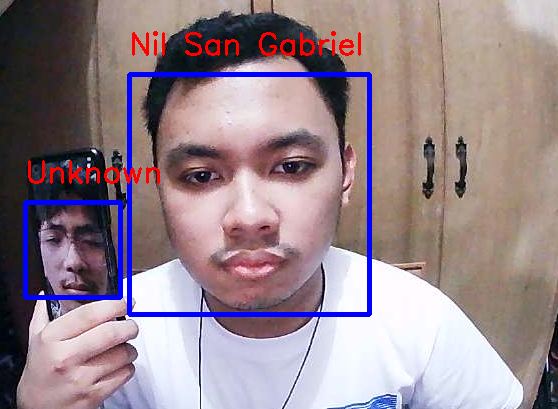

### Mood Detection

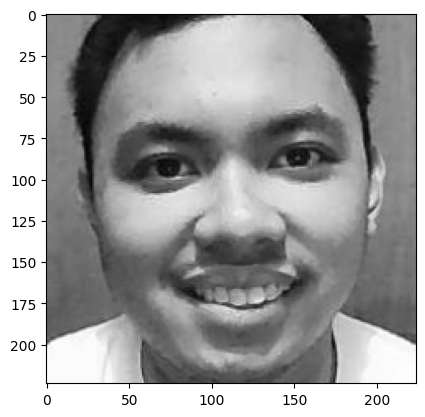

In [70]:
sample_img = cv2.imread(r'D:\vscodeProjects\Data\captured\emotion\happy\happy (1).jpg')
plt.imshow(sample_img)

In [71]:
sample_img.shape

(224, 224, 3)

## Image data generators and splitting of data

In [72]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import mobilenet

In [73]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

train_set = datagen.flow_from_directory(
    directory=r'D:\vscodeProjects\Data\captured\emotion',
    target_size=sample_img.shape[:2],
    batch_size=32,
    subset='training'
)

test_set = datagen.flow_from_directory(
    directory=r'D:\vscodeProjects\Data\captured\emotion',
    target_size=sample_img.shape[:2],
    batch_size=32,
    subset='validation'
)

train_set.class_indices

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


{'angry': 0, 'happy': 1, 'sad': 2, 'surprised': 3}

4 moods where found: `angry`, `happy`, `sad`, and `surprised`

In [74]:
t_img, label = train_set.next()

`train_set.next()' returns the items in the dataset the attributes and the labels

## Model training and validation

In [75]:
## plot the graph
def plot_loss_accuracy(history, name):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    
    plt.suptitle(name)

In [80]:
## Create the model
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=(1, 1),
                 input_shape=sample_img.shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (4, 4), strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(len(train_set.class_indices)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_56 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 108, 108, 64)      32832     
                                                                 
 activation_57 (Activation)  (None, 108, 108, 64)      0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                

 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 86528)             0         
                                                                 
 dense_23 (Dense)            (None, 128)               11075712  
                                                                 
 activation_59 (Activation)  (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 4)                 516       
                                                                 
 activation_60 (Activation)  (None, 4)                 0         
                                                                 
Total params: 11,183,812
Trainable params: 11,183,812
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Checks of the val_accuracy imporved after 5 epochs, then stops if no improvement found
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1)

## saves the model if the val_accuracy improved
model_check = keras.callbacks.ModelCheckpoint(filepath="model_SanGabriel.h5", 
                                              monitor='val_accuracy', 
                                              verbose=1, 
                                              save_best_only= True, 
                                              mode='auto')

history = model.fit_generator(train_set,
                              epochs=30,
                              validation_data=test_set,
                              callbacks=[early_stop, model_check])

Epoch 1/30


C:\Users\Nil\AppData\Local\Temp\ipykernel_3156\3798926856.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set,


12/12 [==============================] - ETA: 0s - loss: 1.6837 - accuracy: 0.2969
Epoch 1: val_accuracy improved from -inf to 0.44792, saving model to model_SanGabriel.h5
12/12 [==============================] - 4s 288ms/step - loss: 1.6837 - accuracy: 0.2969 - val_loss: 1.3468 - val_accuracy: 0.4479
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 1.1966 - accuracy: 0.5807
Epoch 2: val_accuracy improved from 0.44792 to 0.59375, saving model to model_SanGabriel.h5
12/12 [==============================] - 3s 268ms/step - loss: 1.1966 - accuracy: 0.5807 - val_loss: 1.0049 - val_accuracy: 0.5937
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.8359
Epoch 3: val_accuracy improved from 0.59375 to 0.91667, saving model to model_SanGabriel.h5
12/12 [==============================] - 3s 267ms/step - loss: 0.5909 - accuracy: 0.8359 - val_loss: 0.2625 - val_accuracy: 0.9167
Epoch 4/30
12/12 [==============================] - ETA: 0s - l

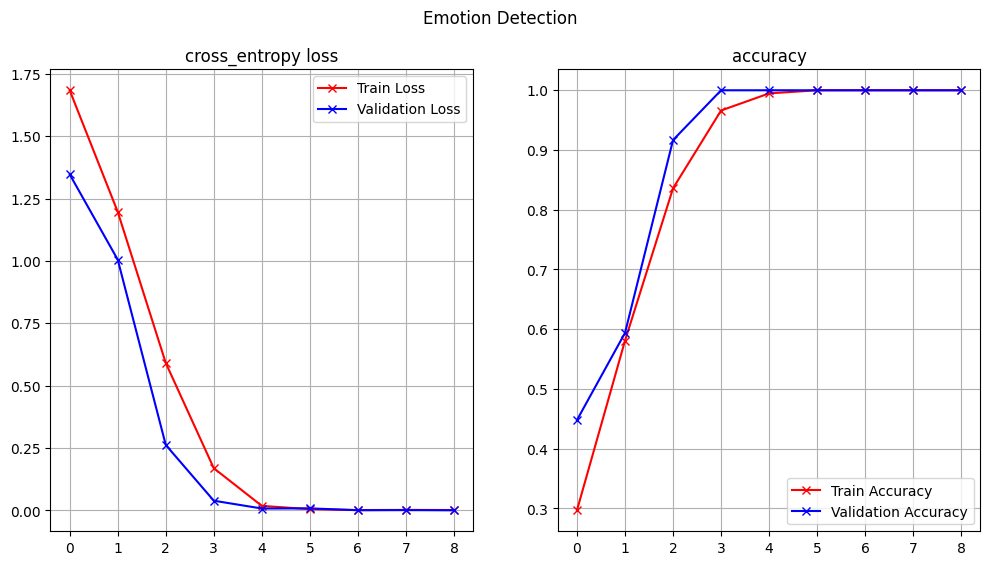

In [82]:
plot_loss_accuracy(history, 'Emotion Detection')

### Mood detection

All functions related to mood detection is in the `mood_detect.py` to prevent from jupyter kernel from dying

In [79]:
'''

import cv2
import numpy as np
import keras.utils as image
from keras.models import load_model

test_model = load_model(r'model_SanGabriel.h5')

face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    ret, test_img = cap.read()  # captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

    for (x, y, w, h) in faces_detected:
        cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 0, 0), thickness=3)
        roi_gray = gray_img[y:y + w, x:x + h]  # cropping region of interest i.e. face area from  image
        roi_gray = cv2.resize(roi_gray, (224, 224))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)
        img_pixels /= 255

        predictions = test_model.predict(img_pixels)

        # find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'happy', 'sad' , 'surprised')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ', resized_img)

    if cv2.waitKey(10) == ord('q'):  # wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

'''

"\n\nimport cv2\nimport numpy as np\nimport keras.utils as image\nfrom keras.models import load_model\n\ntest_model = load_model(r'model_SanGabriel.h5')\n\nface_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')\n\ncap = cv2.VideoCapture(0)\n\nwhile True:\n    ret, test_img = cap.read()  # captures frame and returns boolean value and captured image\n    if not ret:\n        continue\n    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)\n\n    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)\n\n    for (x, y, w, h) in faces_detected:\n        cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 0, 0), thickness=3)\n        roi_gray = gray_img[y:y + w, x:x + h]  # cropping region of interest i.e. face area from  image\n        roi_gray = cv2.resize(roi_gray, (224, 224))\n        img_pixels = image.img_to_array(roi_gray)\n        img_pixels = np.expand_dims(img_pixels, axis=0)\n        img_pixels /= 255\n\n       

| **Happy** | **Sad** | 
| :-: | :-: | 
| 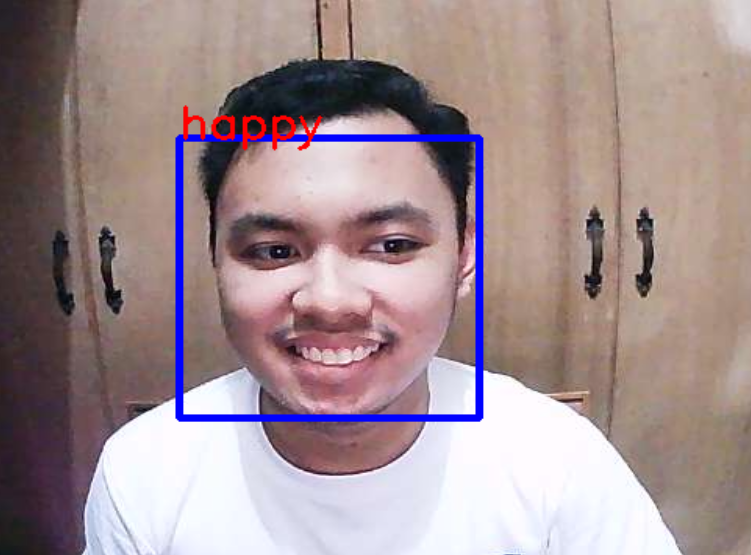 | 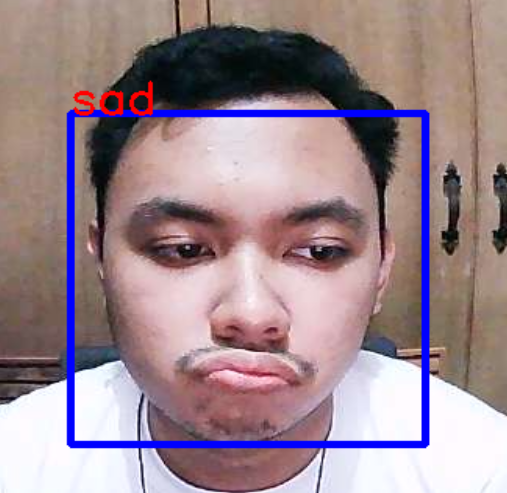 |
| **Angry** | **Surprised** |
| 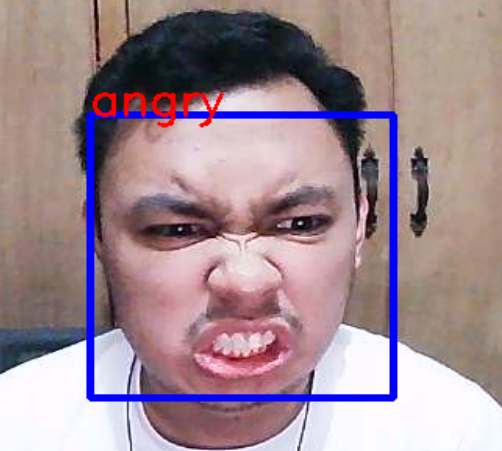 | 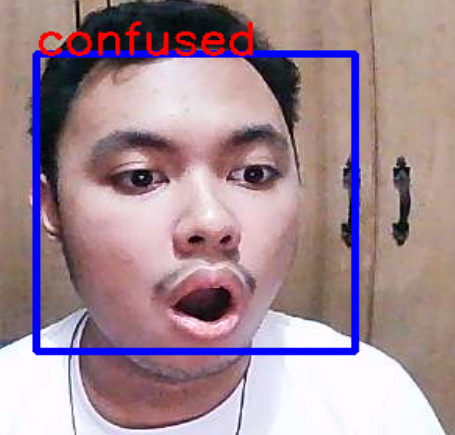 |

Link to photos: [GDrive Folder](https://drive.google.com/drive/folders/1plfuFjmRGnmTTqmGAEHgUVVwvB72rtbw?usp=sharing)